In [ ]:
!pip install -U torch torchvision

In [ ]:
# установка подходящей версии torch

from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/My\ Drive/archive.zip -d task

replace task/cat_to_name.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!ls train

1  10  11  12  13  14  15  2  3  4  5  6  7  8	9


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Mar 18 20:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      2MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [10]:
class CoinsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [21]:
TRAIN_DIR = Path('train')
#тут сменить путь на такой же как для теста
print(TRAIN_DIR)
TEST_DIR = Path('task/test')

train_val_files = list(TRAIN_DIR.rglob('*.jpg')) 
print(train_val_files)
print(list(TEST_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(test_files)

train
[PosixPath('train/6/10_1477186218.jpg'), PosixPath('train/6/10_1477288194.jpg'), PosixPath('train/6/10_1477186242.jpg'), PosixPath('train/6/10_1477289124.jpg'), PosixPath('train/6/10_1477186680.jpg'), PosixPath('train/6/10_1477187172.jpg'), PosixPath('train/6/10_1477288422.jpg'), PosixPath('train/6/10_1477187376.jpg'), PosixPath('train/6/10_1477288626.jpg'), PosixPath('train/6/10_1477186728.jpg'), PosixPath('train/6/10_1477289394.jpg'), PosixPath('train/6/10_1477288176.jpg'), PosixPath('train/6/10_1477289184.jpg'), PosixPath('train/6/10_1477187292.jpg'), PosixPath('train/6/10_1477147392.jpg'), PosixPath('train/6/10_1477186464.jpg'), PosixPath('train/6/10_1477288686.jpg'), PosixPath('train/6/10_1477289544.jpg'), PosixPath('train/6/10_1477288116.jpg'), PosixPath('train/6/10_1477288254.jpg'), PosixPath('train/6/10_1477289040.jpg'), PosixPath('train/6/10_1477288272.jpg'), PosixPath('train/6/10_1477147488.jpg'), PosixPath('train/6/10_1477187058.jpg'), PosixPath('train/6/10_1477187088.

In [22]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [23]:
val_dataset = CoinsDataset(val_files, mode='val')

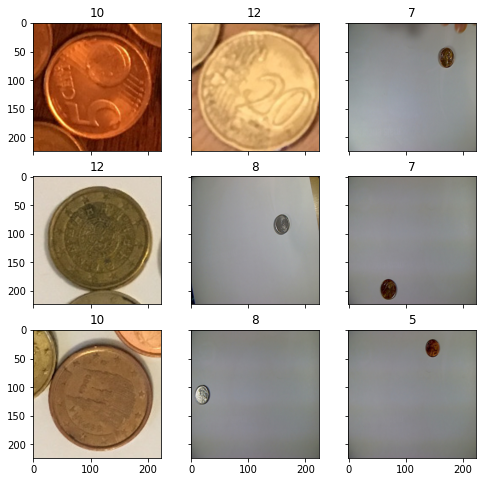

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)
#тут правильно классифицирует, т.к. цифры переводятся в виды монет

In [25]:
import torchvision.models as models

In [26]:
model_1 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_1.parameters():
    param.requires_grad = False

model_1.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 15)
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [27]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    if scheduler is not None:
        scheduler.step()
    return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
    

In [29]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import AdamW

In [36]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.fc.parameters(), lr=0.0005)
        scheduler = ExponentialLR(optimizer=opt, gamma=0.85)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [37]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [38]:
n_classes = len(np.unique(train_val_labels))
my_cnn_1 = model_1.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn_1)

we will classify :11
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

In [39]:
if val_dataset is None:
    val_dataset = CoinsDataset(val_files, mode='val')
    
train_dataset = CoinsDataset(train_files, mode='train')

In [41]:
history = train(train_dataset, val_dataset, model=my_cnn_1, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.4258080196763555


epoch:  10%|█         | 1/10 [00:48<07:14, 48.27s/it]


Epoch 001 train_loss: 0.4258     val_loss 0.4918 train_acc 0.8508 val_acc 0.8264
loss 0.27443437641623364


epoch:  20%|██        | 2/10 [01:36<06:26, 48.28s/it]


Epoch 002 train_loss: 0.2744     val_loss 0.3977 train_acc 0.8937 val_acc 0.8592
loss 0.22678268312532116


epoch:  30%|███       | 3/10 [02:24<05:38, 48.30s/it]


Epoch 003 train_loss: 0.2268     val_loss 0.3959 train_acc 0.9193 val_acc 0.8610
loss 0.1713380852096519


epoch:  40%|████      | 4/10 [03:13<04:49, 48.25s/it]


Epoch 004 train_loss: 0.1713     val_loss 0.3534 train_acc 0.9366 val_acc 0.8687
loss 0.1395619448196026


epoch:  50%|█████     | 5/10 [04:01<04:01, 48.25s/it]


Epoch 005 train_loss: 0.1396     val_loss 0.2779 train_acc 0.9502 val_acc 0.9033
loss 0.09757703520063535


epoch:  60%|██████    | 6/10 [04:49<03:12, 48.22s/it]


Epoch 006 train_loss: 0.0976     val_loss 0.3683 train_acc 0.9686 val_acc 0.8722
loss 0.09139350509564563


epoch:  70%|███████   | 7/10 [05:37<02:24, 48.20s/it]


Epoch 007 train_loss: 0.0914     val_loss 0.2741 train_acc 0.9718 val_acc 0.8964
loss 0.07295568723707009


epoch:  80%|████████  | 8/10 [06:25<01:36, 48.22s/it]


Epoch 008 train_loss: 0.0730     val_loss 0.2736 train_acc 0.9787 val_acc 0.9093
loss 0.05701005373883148


epoch:  90%|█████████ | 9/10 [07:14<00:48, 48.24s/it]


Epoch 009 train_loss: 0.0570     val_loss 0.2723 train_acc 0.9891 val_acc 0.9067
loss 0.0533105389455731


epoch: 100%|██████████| 10/10 [08:02<00:00, 48.26s/it]


Epoch 010 train_loss: 0.0533     val_loss 0.2708 train_acc 0.9891 val_acc 0.9050


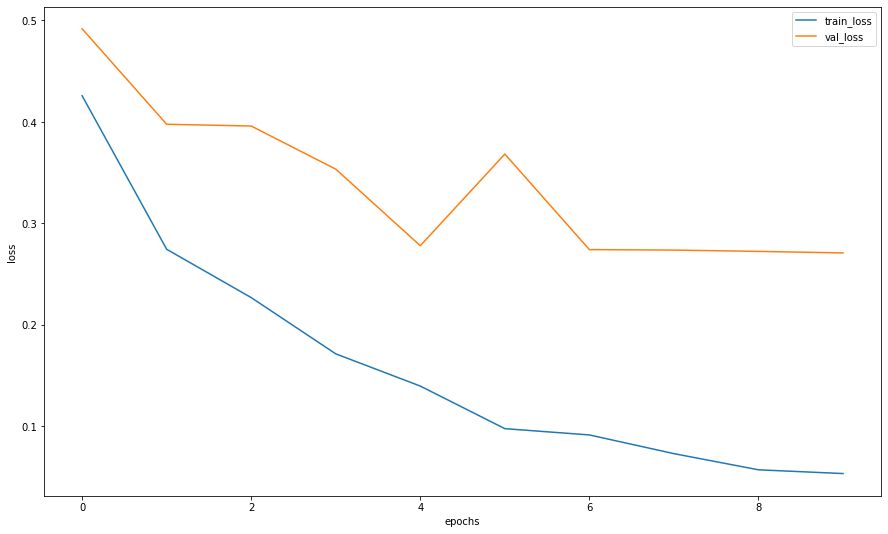

In [43]:
plt.figure(figsize=(15, 9))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [44]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [46]:
random_coins = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn_1, ex_img.unsqueeze(0))
print(probs_im)

[[2.7952382e-07 1.8070965e-08 1.2465007e-07 6.2597827e-08 4.2174101e-08
  1.5890556e-07 9.9691594e-01 5.4597709e-04 1.2719735e-03 1.2652889e-03
  1.5519714e-07 7.5091711e-09 2.0458971e-08 9.8255759e-09 2.1024340e-09]]


In [48]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn_1, imgs)
print(probs_ims)

[[2.94788770e-05 2.29120651e-05 3.36945232e-05 2.20160437e-05
  1.87431688e-05 1.76467802e-05 4.11636472e-01 1.34900004e-01
  3.45313519e-01 1.07599169e-01 3.97211290e-04 2.51998495e-06
  1.80572601e-06 3.37530400e-06 1.49082621e-06]
 [5.57433680e-07 1.64842461e-07 1.11597524e-06 3.44355016e-07
  2.25136390e-07 8.16037158e-08 1.85948908e-01 3.13142751e-04
  8.13719571e-01 8.84538804e-06 7.07981371e-06 2.76719057e-08
  9.15701026e-09 1.02609805e-08 8.40898995e-09]
 [5.94383338e-04 2.28059853e-05 3.30692914e-04 6.65645030e-06
  2.85614601e-06 2.98877103e-06 8.33015144e-01 3.42053957e-02
  1.27602845e-01 4.20606788e-03 2.08369465e-06 2.10057419e-06
  1.38965584e-06 2.90412709e-06 1.74097374e-06]
 [3.96103969e-05 1.85877400e-06 2.09512586e-06 3.16587284e-06
  3.90018931e-06 1.07367523e-05 1.01424428e-02 8.55078936e-01
  7.47798383e-02 1.34296867e-03 5.85937165e-02 1.00942707e-07
  8.07062719e-08 2.54616225e-07 3.78295340e-07]
 [9.99893546e-01 3.65287065e-06 4.87242687e-05 5.17858498e-05
  

In [49]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [50]:
y_pred = np.argmax(probs_ims,-1)
print(y_pred)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
print(preds_class)
print(actual_labels)

[6 8 6 7 0 1 2 5 9 0 6 0 8 9 6 8 3 4 8 7]
['5', '7', '5', '6', '10', '11', '12', '15', '8', '10', '5', '10', '7', '8', '5', '7', '13', '14', '7', '6']
[8, 8, 6, 7, 0, 1, 2, 5, 9, 0, 6, 0, 8, 9, 6, 8, 3, 4, 8, 7]


In [51]:
all_labels = np.unique(train_val_labels)
n_classes = len(all_labels)

In [52]:
from sklearn.metrics import f1_score
preds_class = list(y_pred)
f1_score(actual_labels, preds_class, average='micro')

0.9500000000000001

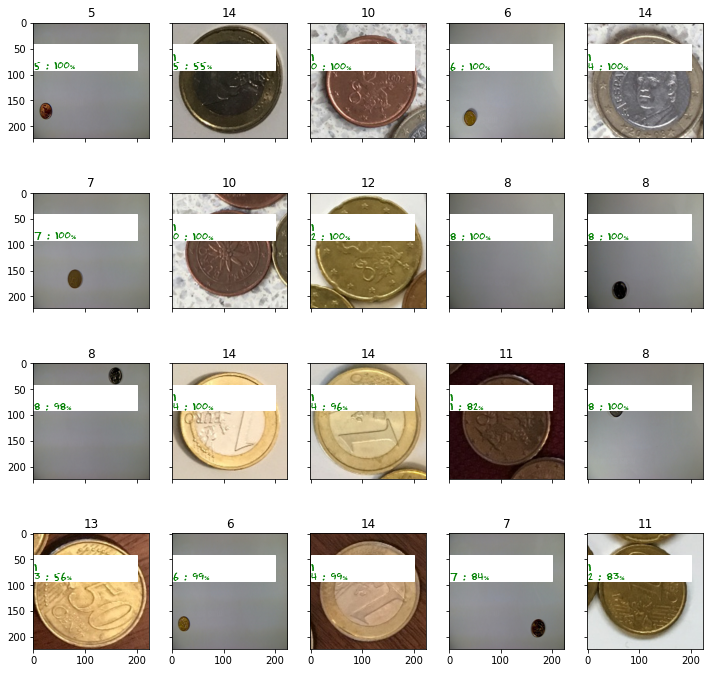

In [54]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 41),200,50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn_1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=11, color='green',fontweight='bold')